<a href="https://colab.research.google.com/github/mircomarahrens/gallus-classifier/blob/main/gcdev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [18]:
results = search_images_ddg('bantam chicken')
print(results)

['http://farm3.static.flickr.com/2146/2281364443_47d35e561f.jpg?v=0', 'https://www.omlet.co.uk/images/originals/pekin_bantam_chickens_lavender_bantam_b4fdec6d7da192d16f1a205b.jpg', 'https://i.pinimg.com/originals/84/cc/1d/84cc1d085ce6da664d6942fbf79a7bdf.jpg', 'https://morningchores.com/wp-content/uploads/2019/12/Japanese-Bantam.jpg', 'https://www.cacklehatchery.com/media/catalog/product/cache/1/image/9df78eab33525d08d6e5fb8d27136e95/6/7/6750285203_90143a1040_z_1.jpg', 'https://leonardgeorge.co.uk/wp-content/uploads/2019/01/G_bantam_chicken_01_40x40_DS.png', 'https://www.somerzby.com.au/wp-content/uploads/2020/02/Bantam-Chicken-Breed-1209x800.jpg', 'https://img.thrfun.com/img/080/860/bantam_chicken_x1.jpg', 'https://i.pinimg.com/originals/36/16/a2/3616a26f0dcb9680b7de103440fd8c56.jpg', 'https://www.omlet.us/images/originals/36_dutchf_fea00419.jpg', 'https://i.pinimg.com/736x/f9/80/fa/f980faebde8e538a8a665269b3e1896b.jpg', 'https://www.animal.photos/bird/chick-bant_files/bantam_rosecomb

In [10]:
len(results) # 200 images of 'bantam'

200

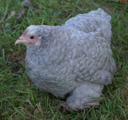

In [11]:
dest = 'images/bantam.jpg'
download_url(results[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [12]:
bantam_types = 'chabo', 'pekin', 'brahma'
path = Path('bantam')

In [21]:
if not path.exists():
    path.mkdir()

for o in bantam_types:
    dest = (path/o)
    if not dest.exists():
        dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} bantam')
    download_images(dest, urls=results)

In [22]:
fns = get_image_files(path)
fns

(#556) [Path('bantam/pekin/7d6d4c5c-9c54-4958-8054-3b47c18e83f7.jpg'),Path('bantam/pekin/b7ba9b68-c2a1-4b42-9f52-5525d1db8427.jpg'),Path('bantam/pekin/a6bf33ab-c475-4b57-9508-83f13f221104.jpg'),Path('bantam/pekin/9e98b672-2d72-4b8c-8cd8-96fbde96537e.jpg'),Path('bantam/pekin/93bee639-628d-4d08-8d37-177a408cb03a.jpg'),Path('bantam/pekin/ea1b79c6-8281-4514-85d5-1752806ce06d.jpg'),Path('bantam/pekin/f5347e66-254d-4f59-a730-72ec4b979ef7.jpg'),Path('bantam/pekin/40b203de-32de-4c8f-8f7e-7fa140bcd994.jpg'),Path('bantam/pekin/942529da-b5fa-4421-8420-4e5c673b605e.jpg'),Path('bantam/pekin/861ed7d9-baa8-40c8-b855-cf45903233f1.JPG')...]

In [23]:
failed = verify_images(fns)
failed

(#9) [Path('bantam/pekin/18a7732e-4092-4715-a22b-0dfced96db15.jpg'),Path('bantam/pekin/e78279ee-347a-496a-9431-3391d4076e1c.jpg'),Path('bantam/chabo/38bd44c9-79e9-43a3-a1e7-d6ed052c6f06.jpg'),Path('bantam/chabo/c2efc97f-26f7-4228-b3c5-135efe9c969e.jpg'),Path('bantam/chabo/1b0577d1-a889-43fd-be24-273e6e6f74ae.jpg'),Path('bantam/brahma/097a4206-7109-4201-9609-b97ab7d4db0e.jpg'),Path('bantam/brahma/9967790d-bafd-4013-81fe-366ed89ec007.jpg'),Path('bantam/brahma/ac38ccc6-acfe-4d5a-ba79-32a7dc9a9863.JPG'),Path('bantam/brahma/aeefbe6a-b659-40c1-8b60-0c8af570a53e.jpg')]

In [24]:
failed.map(Path.unlink)

(#9) [None,None,None,None,None,None,None,None,None]

In [25]:
bantams = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [26]:
dls = bantams.dataloaders(path)

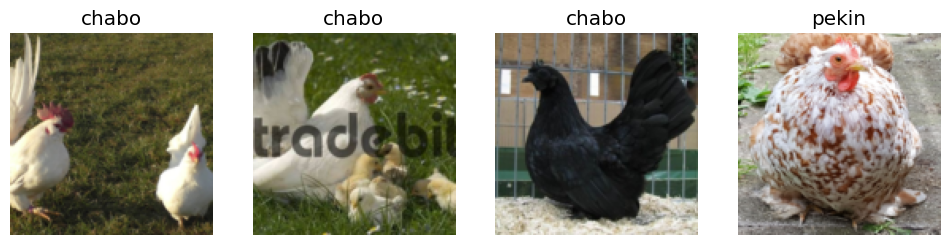

In [27]:
dls.valid.show_batch(max_n=4, nrows=1)

In [30]:
bantams = bantams.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bantams.dataloaders(path)

In [31]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 93.3MB/s]


In [32]:
learn.fine_tune(4)

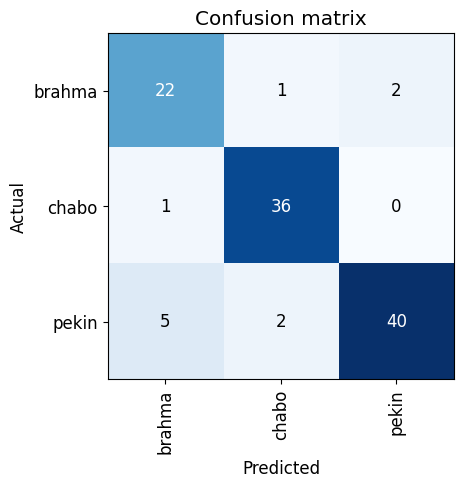

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

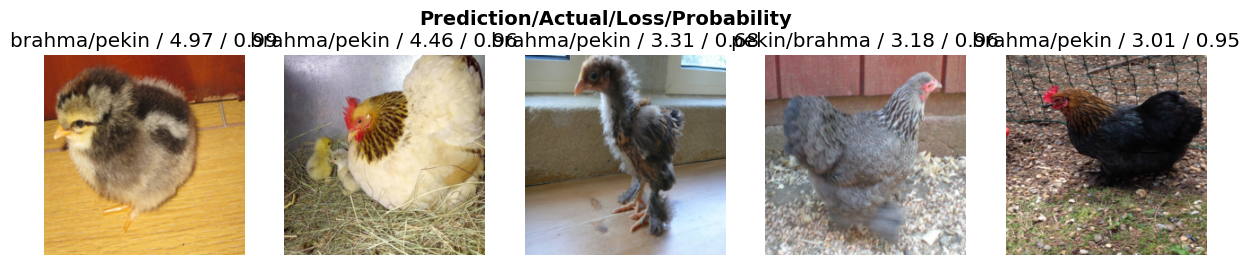

In [34]:
interp.plot_top_losses(5, nrows=1)

In [35]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [36]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [37]:
learn.export()

In [38]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [39]:
learn_inf = load_learner(path/'export.pkl')

In [40]:
learn_inf.predict('images/bantam.jpg')

('pekin', tensor(2), tensor([1.6866e-04, 4.3457e-05, 9.9979e-01]))

In [41]:
learn_inf.dls.vocab

['brahma', 'chabo', 'pekin']